In [1]:
train_dir = 'D:/Documentos/Estudio/Maestria/1-Periodo/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Train' 
val_dir = 'D:/Documentos/Estudio/Maestria/1-Periodo/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Val' 
test_dir = 'D:/Documentos/Estudio/Maestria/1-Periodo/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Test'

In [2]:
#ELEGIMOS LOS PARAMETROS
from keras.preprocessing.image import ImageDataGenerator
ih, iw = 224,224 #tamano de la imagen
input_shape = (ih, iw, 3) #forma de la imagen: alto ancho y numero de canales

num_class = 2 #cuantas clases 
#epochs = 15 #cuantas veces entrenar. En cada epoch hace una mejora en los parametros

batch_size = 32 #batch para hacer cada entrenamiento. Lee 50 'batch_size' imagenes antes de actualizar los parametros. Las carga a memoria
num_train = 21715 #numero de imagenes en train
num_test = 6788 #numero de imagenes en test
num_val=5417

epoch_steps = num_train // batch_size 
test_steps = num_test // batch_size
 

In [3]:
#LEEMOS LAS IMÁGENES 

img_height, img_width=ih, iw

train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as training data

validation_generator = train_datagen.flow_from_directory(
    val_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

test_generator = train_datagen.flow_from_directory(
    test_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

Found 14507 images belonging to 2 classes.
Found 3615 images belonging to 2 classes.
Found 4535 images belonging to 2 classes.


In [4]:
train=train_generator
val=validation_generator
test=test_generator

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, DenseNet121, ResNet152V2, NASNetLarge
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from keras.applications import resnet_v2
from keras.applications import nasnet 

nasnet_model = nasnet.NASNetMobile(include_top=False, weights='imagenet',  
                                     input_shape=input_shape) 

nasnet_model.trainable=False
for layer in nasnet_model.layers: 
    layer.trainable = False 

In [6]:
#for layer in Xception_model.layers[:-40]:
#    layer.trainable = False

In [7]:
import pandas as pd 
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in nasnet_model.layers] 
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

C:\Users\elium\AppData\Local\Temp\ipykernel_3856\2643193883.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x000001CB3FAD6260>,input_1,False
1,<keras.layers.convolutional.conv2d.Conv2D object at 0x000001CB405267A0>,stem_conv1,False
2,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001CB40503A60>,stem_bn1,False
3,<keras.layers.core.activation.Activation object at 0x000001CB40503970>,activation,False
4,<keras.layers.convolutional.conv2d.Conv2D object at 0x000001CB404D63E0>,reduction_conv_1_stem_1,False
...,...,...,...
764,<keras.layers.merging.add.Add object at 0x000001CDCBA7D420>,normal_add_3_12,False
765,<keras.layers.merging.add.Add object at 0x000001CDCBA938B0>,normal_add_4_12,False
766,<keras.layers.merging.add.Add object at 0x000001CDCBAAAB00>,normal_add_5_12,False
767,<keras.layers.merging.concatenate.Concatenate object at 0x000001CDCBAAB0D0>,normal_concat_12,False


In [8]:
nasnet_model.summary()

Model: "NASNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 111, 111, 32  128         ['stem_conv1[0][0]']             
                                )                                                            

                                                                                                  
 separable_conv_1_pad_reduction  (None, 115, 115, 32  0          ['activation_7[0][0]']           
 _right3_stem_1 (ZeroPadding2D)  )                                                                
                                                                                                  
 activation_9 (Activation)      (None, 56, 56, 11)   0           ['reduction_add_1_stem_1[0][0]'] 
                                                                                                  
 separable_conv_1_bn_reduction_  (None, 56, 56, 11)  44          ['separable_conv_1_reduction_righ
 right2_stem_1 (BatchNormalizat                                  t2_stem_1[0][0]']                
 ion)                                                                                             
                                                                                                  
 separable

 add (Add)                      (None, 56, 56, 11)   0           ['reduction_add_2_stem_1[0][0]', 
                                                                  'reduction_left4_stem_1[0][0]'] 
                                                                                                  
 reduction_add4_stem_1 (Add)    (None, 56, 56, 11)   0           ['separable_conv_2_bn_reduction_l
                                                                 eft4_stem_1[0][0]',              
                                                                  'reduction_right5_stem_1[0][0]']
                                                                                                  
 cropping2d (Cropping2D)        (None, 111, 111, 32  0           ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                                  
 reduction

 separable_conv_2_bn_reduction_  (None, 28, 28, 22)  88          ['separable_conv_2_reduction_righ
 right1_stem_2 (BatchNormalizat                                  t1_stem_2[0][0]']                
 ion)                                                                                             
                                                                                                  
 separable_conv_1_pad_reduction  (None, 61, 61, 22)  0           ['activation_16[0][0]']          
 _right2_stem_2 (ZeroPadding2D)                                                                   
                                                                                                  
 activation_18 (Activation)     (None, 56, 56, 22)   0           ['adjust_bn_stem_2[0][0]']       
                                                                                                  
 reduction_add_1_stem_2 (Add)   (None, 28, 28, 22)   0           ['separable_conv_2_bn_reduction_l
          

                                                                                                  
 separable_conv_2_bn_reduction_  (None, 28, 28, 22)  88          ['separable_conv_2_reduction_left
 left4_stem_2 (BatchNormalizati                                  4_stem_2[0][0]']                 
 on)                                                                                              
                                                                                                  
 reduction_right5_stem_2 (MaxPo  (None, 28, 28, 22)  0           ['reduction_pad_1_stem_2[0][0]'] 
 oling2D)                                                                                         
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 57, 57, 44)  0           ['adjust_relu_1_0[0][0]']        
 D)                                                                                               
          

 separable_conv_1_bn_normal_lef  (None, 28, 28, 44)  176         ['separable_conv_1_normal_left2_0
 t2_0 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_1_bn_normal_rig  (None, 28, 28, 44)  176         ['separable_conv_1_normal_right2_
 ht2_0 (BatchNormalization)                                      0[0][0]']                        
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 28, 28, 44)  176         ['separable_conv_1_normal_left5_0
 t5_0 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 activation_24 (Activation)     (None, 28, 28, 44)   0           ['separable_conv_1_bn_normal_left
          

 normal_concat_0 (Concatenate)  (None, 28, 28, 264)  0           ['adjust_bn_0[0][0]',            
                                                                  'normal_add_1_0[0][0]',         
                                                                  'normal_add_2_0[0][0]',         
                                                                  'normal_add_3_0[0][0]',         
                                                                  'normal_add_4_0[0][0]',         
                                                                  'normal_add_5_0[0][0]']         
                                                                                                  
 activation_33 (Activation)     (None, 28, 28, 88)   0           ['reduction_concat_stem_2[0][0]']
                                                                                                  
 activation_34 (Activation)     (None, 28, 28, 264)  0           ['normal_concat_0[0][0]']        
          

 separable_conv_2_normal_left2_  (None, 28, 28, 44)  3036        ['activation_40[0][0]']          
 1 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_normal_right2  (None, 28, 28, 44)  2332        ['activation_42[0][0]']          
 _1 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_left5_  (None, 28, 28, 44)  2332        ['activation_44[0][0]']          
 1 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 28, 28, 44)  176         ['separable_conv_2_normal_left1_1
 t1_1 (Bat

 activation_55 (Activation)     (None, 28, 28, 44)   0           ['normal_bn_1_2[0][0]']          
                                                                                                  
 separable_conv_1_normal_left1_  (None, 28, 28, 44)  3036        ['activation_47[0][0]']          
 2 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_1_normal_right1  (None, 28, 28, 44)  2332        ['activation_49[0][0]']          
 _2 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_1_normal_left2_  (None, 28, 28, 44)  3036        ['activation_51[0][0]']          
 2 (SeparableConv2D)                                                                              
          

 separable_conv_2_bn_normal_lef  (None, 28, 28, 44)  176         ['separable_conv_2_normal_left5_2
 t5_2 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 normal_add_1_2 (Add)           (None, 28, 28, 44)   0           ['separable_conv_2_bn_normal_left
                                                                 1_2[0][0]',                      
                                                                  'separable_conv_2_bn_normal_righ
                                                                 t1_2[0][0]']                     
                                                                                                  
 normal_add_2_2 (Add)           (None, 28, 28, 44)   0           ['separable_conv_2_bn_normal_left
                                                                 2_2[0][0]',                      
          

 t5_3 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 activation_60 (Activation)     (None, 28, 28, 44)   0           ['separable_conv_1_bn_normal_left
                                                                 1_3[0][0]']                      
                                                                                                  
 activation_62 (Activation)     (None, 28, 28, 44)   0           ['separable_conv_1_bn_normal_righ
                                                                 t1_3[0][0]']                     
                                                                                                  
 activation_64 (Activation)     (None, 28, 28, 44)   0           ['separable_conv_1_bn_normal_left
                                                                 2_3[0][0]']                      
          

 activation_70 (Activation)     (None, 28, 28, 264)  0           ['normal_concat_3[0][0]']        
                                                                                                  
 activation_69 (Activation)     (None, 28, 28, 264)  0           ['normal_concat_2[0][0]']        
                                                                                                  
 reduction_conv_1_reduce_4 (Con  (None, 28, 28, 88)  23232       ['activation_70[0][0]']          
 v2D)                                                                                             
                                                                                                  
 adjust_conv_projection_reduce_  (None, 28, 28, 88)  23232       ['activation_69[0][0]']          
 4 (Conv2D)                                                                                       
                                                                                                  
 reduction

                                                                 ]                                
                                                                                                  
 separable_conv_1_bn_reduction_  (None, 14, 14, 88)  352         ['separable_conv_1_reduction_righ
 right2_reduce_4 (BatchNormaliz                                  t2_reduce_4[0][0]']              
 ation)                                                                                           
                                                                                                  
 separable_conv_1_reduction_rig  (None, 14, 14, 88)  9944        ['separable_conv_1_pad_reduction_
 ht3_reduce_4 (SeparableConv2D)                                  right3_reduce_4[0][0]']          
                                                                                                  
 separable_conv_1_reduction_lef  (None, 14, 14, 88)  8536        ['activation_79[0][0]']          
 t4_reduce

                                                                 eft4_reduce_4[0][0]',            
                                                                  'reduction_right5_reduce_4[0][0]
                                                                 ']                               
                                                                                                  
 cropping2d_2 (Cropping2D)      (None, 28, 28, 264)  0           ['zero_padding2d_2[0][0]']       
                                                                                                  
 reduction_concat_reduce_4 (Con  (None, 14, 14, 352)  0          ['reduction_add_2_reduce_4[0][0]'
 catenate)                                                       , 'reduction_add3_reduce_4[0][0]'
                                                                 , 'add_2[0][0]',                 
                                                                  'reduction_add4_reduce_4[0][0]']
          

                                                                                                  
 activation_89 (Activation)     (None, 14, 14, 88)   0           ['separable_conv_1_bn_normal_righ
                                                                 t2_5[0][0]']                     
                                                                                                  
 activation_91 (Activation)     (None, 14, 14, 88)   0           ['separable_conv_1_bn_normal_left
                                                                 5_5[0][0]']                      
                                                                                                  
 separable_conv_2_normal_left1_  (None, 14, 14, 88)  9944        ['activation_83[0][0]']          
 5 (SeparableConv2D)                                                                              
                                                                                                  
 separable

 adjust_bn_6 (BatchNormalizatio  (None, 14, 14, 88)  352         ['adjust_conv_projection_6[0][0]'
 n)                                                              ]                                
                                                                                                  
 normal_bn_1_6 (BatchNormalizat  (None, 14, 14, 88)  352         ['normal_conv_1_6[0][0]']        
 ion)                                                                                             
                                                                                                  
 activation_94 (Activation)     (None, 14, 14, 88)   0           ['normal_bn_1_6[0][0]']          
                                                                                                  
 activation_96 (Activation)     (None, 14, 14, 88)   0           ['adjust_bn_6[0][0]']            
                                                                                                  
 activatio

 t2_6 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_2_bn_normal_rig  (None, 14, 14, 88)  352         ['separable_conv_2_normal_right2_
 ht2_6 (BatchNormalization)                                      6[0][0]']                        
                                                                                                  
 normal_left3_6 (AveragePooling  (None, 14, 14, 88)  0           ['normal_bn_1_6[0][0]']          
 2D)                                                                                              
                                                                                                  
 normal_left4_6 (AveragePooling  (None, 14, 14, 88)  0           ['adjust_bn_6[0][0]']            
 2D)                                                                                              
          

                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 14, 14, 88)  352         ['separable_conv_1_normal_left1_7
 t1_7 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_1_bn_normal_rig  (None, 14, 14, 88)  352         ['separable_conv_1_normal_right1_
 ht1_7 (BatchNormalization)                                      7[0][0]']                        
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 14, 14, 88)  352         ['separable_conv_1_normal_left2_7
 t2_7 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable

 normal_add_4_7 (Add)           (None, 14, 14, 88)   0           ['normal_left4_7[0][0]',         
                                                                  'normal_right4_7[0][0]']        
                                                                                                  
 normal_add_5_7 (Add)           (None, 14, 14, 88)   0           ['separable_conv_2_bn_normal_left
                                                                 5_7[0][0]',                      
                                                                  'normal_bn_1_7[0][0]']          
                                                                                                  
 normal_concat_7 (Concatenate)  (None, 14, 14, 528)  0           ['adjust_bn_7[0][0]',            
                                                                  'normal_add_1_7[0][0]',         
                                                                  'normal_add_2_7[0][0]',         
          

                                                                                                  
 separable_conv_2_normal_left1_  (None, 14, 14, 88)  9944        ['activation_119[0][0]']         
 8 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_normal_right1  (None, 14, 14, 88)  8536        ['activation_121[0][0]']         
 _8 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_left2_  (None, 14, 14, 88)  9944        ['activation_123[0][0]']         
 8 (SeparableConv2D)                                                                              
                                                                                                  
 separable

 activation_130 (Activation)    (None, 14, 14, 176)  0           ['reduction_bn_1_reduce_8[0][0]']
                                                                                                  
 activation_132 (Activation)    (None, 14, 14, 176)  0           ['adjust_bn_reduce_8[0][0]']     
                                                                                                  
 separable_conv_1_pad_reduction  (None, 17, 17, 176)  0          ['activation_130[0][0]']         
 _left1_reduce_8 (ZeroPadding2D                                                                   
 )                                                                                                
                                                                                                  
 separable_conv_1_pad_reduction  (None, 19, 19, 176)  0          ['activation_132[0][0]']         
 _right1_reduce_8 (ZeroPadding2                                                                   
 D)       

 right3_reduce_8 (BatchNormaliz                                  t3_reduce_8[0][0]']              
 ation)                                                                                           
                                                                                                  
 separable_conv_1_bn_reduction_  (None, 7, 7, 176)   704         ['separable_conv_1_reduction_left
 left4_reduce_8 (BatchNormaliza                                  4_reduce_8[0][0]']               
 tion)                                                                                            
                                                                                                  
 reduction_pad_1_reduce_8 (Zero  (None, 15, 15, 176)  0          ['reduction_bn_1_reduce_8[0][0]']
 Padding2D)                                                                                       
                                                                                                  
 separable

                                                                                                  
 adjust_conv_1_9 (Conv2D)       (None, 7, 7, 88)     46464       ['adjust_avg_pool_1_9[0][0]']    
                                                                                                  
 adjust_conv_2_9 (Conv2D)       (None, 7, 7, 88)     46464       ['adjust_avg_pool_2_9[0][0]']    
                                                                                                  
 activation_140 (Activation)    (None, 7, 7, 704)    0           ['reduction_concat_reduce_8[0][0]
                                                                 ']                               
                                                                                                  
 concatenate_3 (Concatenate)    (None, 7, 7, 176)    0           ['adjust_conv_1_9[0][0]',        
                                                                  'adjust_conv_2_9[0][0]']        
          

 separable_conv_2_normal_right2  (None, 7, 7, 176)   32560       ['activation_148[0][0]']         
 _9 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_left5_  (None, 7, 7, 176)   32560       ['activation_150[0][0]']         
 9 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 7, 7, 176)   704         ['separable_conv_2_normal_left1_9
 t1_9 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_2_bn_normal_rig  (None, 7, 7, 176)   704         ['separable_conv_2_normal_right1_
 ht1_9 (Ba

 separable_conv_1_normal_left1_  (None, 7, 7, 176)   35376       ['activation_153[0][0]']         
 10 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_1_normal_right1  (None, 7, 7, 176)   32560       ['activation_155[0][0]']         
 _10 (SeparableConv2D)                                                                            
                                                                                                  
 separable_conv_1_normal_left2_  (None, 7, 7, 176)   35376       ['activation_157[0][0]']         
 10 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_1_normal_right2  (None, 7, 7, 176)   32560       ['activation_159[0][0]']         
 _10 (Sepa

                                                                                                  
 normal_add_1_10 (Add)          (None, 7, 7, 176)    0           ['separable_conv_2_bn_normal_left
                                                                 1_10[0][0]',                     
                                                                  'separable_conv_2_bn_normal_righ
                                                                 t1_10[0][0]']                    
                                                                                                  
 normal_add_2_10 (Add)          (None, 7, 7, 176)    0           ['separable_conv_2_bn_normal_left
                                                                 2_10[0][0]',                     
                                                                  'separable_conv_2_bn_normal_righ
                                                                 t2_10[0][0]']                    
          

 activation_166 (Activation)    (None, 7, 7, 176)    0           ['separable_conv_1_bn_normal_left
                                                                 1_11[0][0]']                     
                                                                                                  
 activation_168 (Activation)    (None, 7, 7, 176)    0           ['separable_conv_1_bn_normal_righ
                                                                 t1_11[0][0]']                    
                                                                                                  
 activation_170 (Activation)    (None, 7, 7, 176)    0           ['separable_conv_1_bn_normal_left
                                                                 2_11[0][0]']                     
                                                                                                  
 activation_172 (Activation)    (None, 7, 7, 176)    0           ['separable_conv_1_bn_normal_righ
          

 activation_176 (Activation)    (None, 7, 7, 1056)   0           ['normal_concat_11[0][0]']       
                                                                                                  
 adjust_conv_projection_12 (Con  (None, 7, 7, 176)   185856      ['activation_175[0][0]']         
 v2D)                                                                                             
                                                                                                  
 normal_conv_1_12 (Conv2D)      (None, 7, 7, 176)    185856      ['activation_176[0][0]']         
                                                                                                  
 adjust_bn_12 (BatchNormalizati  (None, 7, 7, 176)   704         ['adjust_conv_projection_12[0][0]
 on)                                                             ']                               
                                                                                                  
 normal_bn

 separable_conv_2_bn_normal_lef  (None, 7, 7, 176)   704         ['separable_conv_2_normal_left1_1
 t1_12 (BatchNormalization)                                      2[0][0]']                        
                                                                                                  
 separable_conv_2_bn_normal_rig  (None, 7, 7, 176)   704         ['separable_conv_2_normal_right1_
 ht1_12 (BatchNormalization)                                     12[0][0]']                       
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 7, 7, 176)   704         ['separable_conv_2_normal_left2_1
 t2_12 (BatchNormalization)                                      2[0][0]']                        
                                                                                                  
 separable_conv_2_bn_normal_rig  (None, 7, 7, 176)   704         ['separable_conv_2_normal_right2_
 ht2_12 (B

In [9]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [10]:
from keras.models import Model 
#from keras.applications.inception_resnet_v2 import preprocess_input
import keras 
import matplotlib.pyplot as plt 
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential 
from keras import optimizers 

# build model architecture 
model = Sequential()
model.add(nasnet_model)
model.add(Flatten())

model.add(Dense(num_class, activation='sigmoid'))
#compile model
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True), 
      metrics=['accuracy',f1_m,precision_m, recall_m])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 7, 7, 1056)        4269716   
                                                                 
 flatten (Flatten)           (None, 51744)             0         
                                                                 
 dense (Dense)               (None, 2)                 103490    
                                                                 
Total params: 4,373,206
Trainable params: 103,490
Non-trainable params: 4,269,716
_________________________________________________________________
None


C:\Users\elium\.conda\envs\enviromentalGPU\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:
history = model.fit_generator(train, 
                              epochs=15,  
                              validation_data=val,  
                              verbose=1)

Epoch 1/15


C:\Users\elium\AppData\Local\Temp\ipykernel_3856\1271991653.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train,
C:\Users\elium\.conda\envs\enviromentalGPU\lib\site-packages\keras\backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


454/454 [==============================] - 56s 99ms/step - loss: 0.3149 - accuracy: 0.8702 - f1_m: 0.8609 - precision_m: 0.8650 - recall_m: 0.8583 - val_loss: 0.1852 - val_accuracy: 0.9248 - val_f1_m: 0.9140 - val_precision_m: 0.9183 - val_recall_m: 0.9109
Epoch 2/15
454/454 [==============================] - 41s 90ms/step - loss: 0.1727 - accuracy: 0.9301 - f1_m: 0.9185 - precision_m: 0.9199 - recall_m: 0.9183 - val_loss: 0.1791 - val_accuracy: 0.9267 - val_f1_m: 0.9193 - val_precision_m: 0.9231 - val_recall_m: 0.9167
Epoch 3/15
454/454 [==============================] - 41s 90ms/step - loss: 0.1408 - accuracy: 0.9438 - f1_m: 0.9330 - precision_m: 0.9357 - recall_m: 0.9312 - val_loss: 0.1522 - val_accuracy: 0.9422 - val_f1_m: 0.9324 - val_precision_m: 0.9368 - val_recall_m: 0.9292
Epoch 4/15
454/454 [==============================] - 41s 90ms/step - loss: 0.1245 - accuracy: 0.9491 - f1_m: 0.9398 - precision_m: 0.9416 - recall_m: 0.9390 - val_loss: 0.1588 - val_accuracy: 0.9372 - val_f

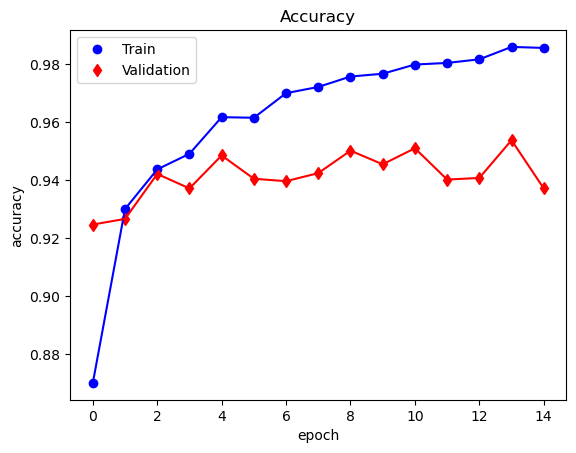

In [12]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],'o',color='blue')
plt.plot(history.history['val_accuracy'],'d',color='red')
plt.plot(history.history['accuracy'],color='blue')
plt.plot(history.history['val_accuracy'],color='red')
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

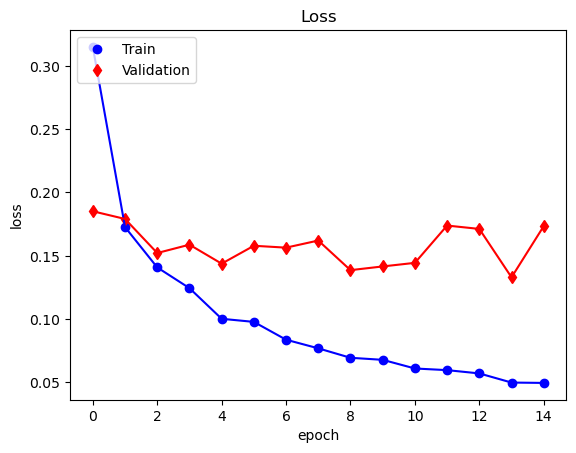

In [13]:
plt.plot(history.history['loss'],'o',color='blue')
plt.plot(history.history['val_loss'],'d',color='red')
plt.plot(history.history['loss'],color='blue')
plt.plot(history.history['val_loss'],color='red')
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

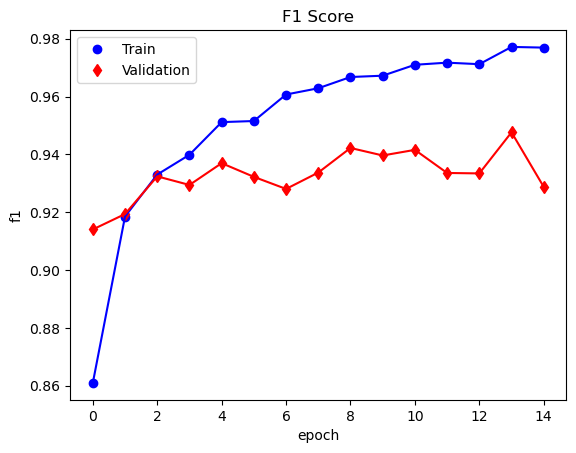

In [14]:
plt.plot(history.history['f1_m'],'o',color='blue')
plt.plot(history.history['val_f1_m'],'d',color='red')
plt.plot(history.history['f1_m'],color='blue')
plt.plot(history.history['val_f1_m'],color='red')
plt.title('F1 Score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

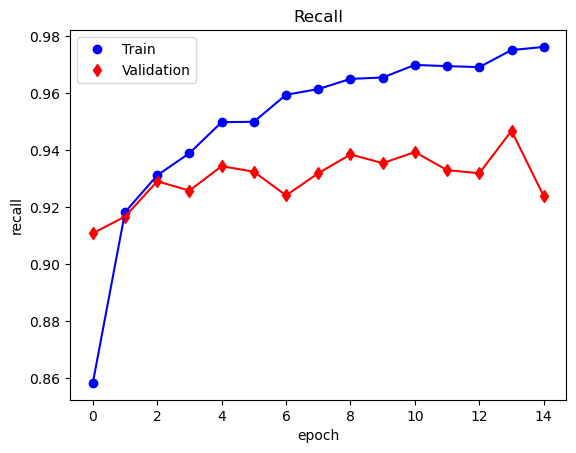

In [15]:
plt.plot(history.history['recall_m'],'o',color='blue')
plt.plot(history.history['val_recall_m'],'d',color='red')
plt.plot(history.history['recall_m'],color='blue')
plt.plot(history.history['val_recall_m'],color='red')
plt.title('Recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

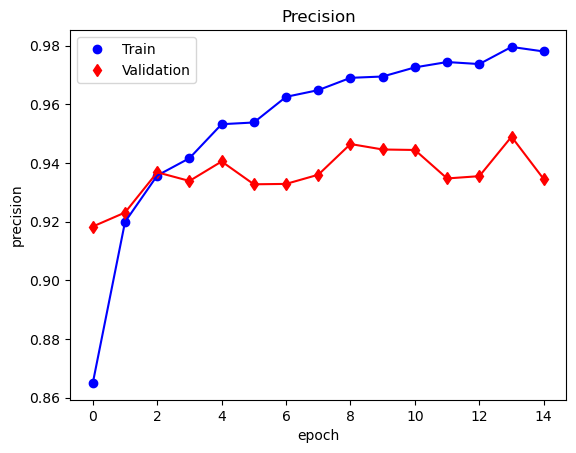

In [16]:
plt.plot(history.history['precision_m'],'o',color='blue')
plt.plot(history.history['val_precision_m'],'d',color='red')
plt.plot(history.history['precision_m'],color='blue')
plt.plot(history.history['val_precision_m'],color='red')
plt.title('Precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [17]:
print('Utilizando el conjunto de datos de test para evaluar el modelo')
test_eval = model.evaluate(test, verbose=1)
print('El modelo predice el ', test_eval[1]*100,'% de los datos')

Utilizando el conjunto de datos de test para evaluar el modelo
142/142 [==============================] - 11s 74ms/step - loss: 0.1368 - accuracy: 0.9442 - f1_m: 0.9391 - precision_m: 0.9421 - recall_m: 0.9370
El modelo predice el  94.42116618156433 % de los datos


In [18]:
print('Utilizando el conjunto de datos de test para evaluar el modelo')
print('Loss: ',test_eval[0])
print('Accuracy: ',test_eval[1])
print('F1 Score: ',test_eval[2])
print('Precision: ',test_eval[3])
print('Recall: ',test_eval[4])

Utilizando el conjunto de datos de test para evaluar el modelo
Loss:  0.1367749273777008
Accuracy:  0.9442116618156433
F1 Score:  0.9391472935676575
Precision:  0.9420529007911682
Recall:  0.9370216131210327
